In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer, WhitespaceTokenizer

from scipy.stats import ttest_ind, shapiro, wilcoxon, norm, normaltest
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score
from resources.modelling import filter_noise

In [2]:
MODELS = {
#    "Gemma 1.1 - 2B": "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B": "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B": "google/gemma-2-9b-it",
#    "Gemma 2.0 - 27B":  "google/gemma-2-27b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
#    "Llama 3.2 - 1B": "meta-llama/Llama-3.2-1B-Instruct",
#    "Llama 3.2 - 3B": "meta-llama/Llama-3.2-3B-Instruct"
}
LABELS = np.array(['allergens', 'biological', 'foreign bodies', 'chemical', 'organoleptic aspects', 'fraud'], dtype=object)

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS       = {}
PROBABILITIES = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/food incidents - hazard/ablations/{MODELS[key]}_saliency.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    with open(f'results/food incidents - hazard/ablations/{MODELS[key]}_probability.pkl', 'rb') as file:
        PROBABILITIES[key] = pickle.load(file)
    print(f'Loaded {key} (dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 7B (dt=100.68 ms).
Loaded Gemma 2.0 - 9B (dt=94.05 ms).
Loaded Llama 3.1 - 8B (dt=281.22 ms).


In [4]:
METHODS = ['AGrad', 'GradIn', 'GradH']
AGGREGATIONS = ['approximated', 'saliency', 'cumsum', 'equal']

In [5]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the reason for the recall of the food product in the following announcement?

"Sainsbury's recalls all codes of its own brand So Organic Fruit and Nut Mix due to salmonella contamination"

Assign one of the following labels: "biological", "allergens", "chemical", "foreign bodies", "organoleptic aspects", or "fraud". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{biological} \\


\hline

\end{tabular}


# Some stats:

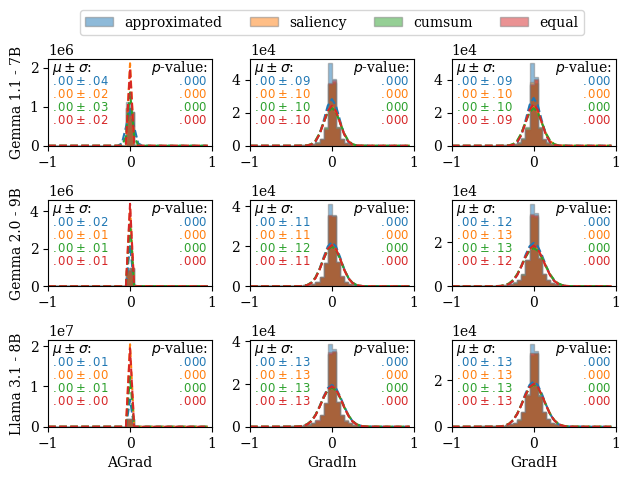

In [6]:
fig, axs = plt.subplots(len(RESULTS), len(METHODS))

for i, model in enumerate(RESULTS):
    values = {a:{m:[] for m in METHODS} for a in AGGREGATIONS}
    for r in RESULTS[model]:
        for m in METHODS:
            for a in AGGREGATIONS:
                values[a][m].extend(r[f'{m}-{a}'].flatten())

    for j, m in enumerate(METHODS):
        x    = np.arange(-1., 1., .05)
        bins = np.arange(-.95, .95, .05)

        # get probability distribution:
        patches, rows = [], []
        for a in AGGREGATIONS:
            vs      = np.array(values[a][m])
            vs      = vs[(vs >= -1) & (vs <= 1)]
            _, p    = normaltest(vs)
            mu, std = norm.fit(vs)
            y       = norm.pdf(x, mu, std)
            
            n, _, b = axs[i,j].hist(vs, bins=bins, histtype='stepfilled', alpha=0.5, edgecolor='gray', label='precise')
            c = b[0].get_fc()[:-1]
            
            axs[i,j].plot(x, y*n.sum()*.05, color=c, ls='dashed')

            rows.append((f'{np.abs(mu):.2f}'[1:], f'{std:.2f}'[1:], f'{p:.3f}'[1:], c))
            patches.append((b[0], a))

        y, step = axs[i,j].get_ylim()[1] * .85, axs[i,j].get_ylim()[1] * .15
        axs[i,j].text(-.95, y, '$\\mu \\pm \\sigma$:', horizontalalignment='left')
        axs[i,j].text( .95, y, '$p$-value:', horizontalalignment='right')

        for mu, std, p, c in rows:
            y -= step
            axs[i,j].text(-.95, y, f'${mu}\\pm{std}$', horizontalalignment='left', color=c, size='smaller')
            axs[i,j].text( .95, y, f'${p}$', horizontalalignment='right', color=c, size='smaller')

        axs[i,j].set_xlim(-1, 1)
        axs[i,j].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# set x-axis titles:
for j, method in enumerate(METHODS): axs[-1,j].set_xlabel(method)

# set y-axis titles:
for i, model in enumerate(RESULTS): axs[i,0].set_ylabel(model)

plt.tight_layout(rect=[0, 0, 1, .95])
axs[0,1].legend(*list(zip(*patches)), ncols=4, bbox_to_anchor=(0, 1.2, 1, 0), loc="lower center")
plt.savefig('plots/stats.pdf')
plt.show()

# Performance:

In [7]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text']) for item in RESULTS[model]])

    ls = np.unique(y_true)
    y_true = np.array([y_true == l for l in ls]).T
    y_pred = np.array([y_pred == l for l in ls]).T
    
    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 7B
  F1:           0.48
  precision:    0.61
  recall:       0.48

Gemma 2.0 - 9B
  F1:           0.53
  precision:    0.63
  recall:       0.51

Llama 3.1 - 8B
  F1:           0.44
  precision:    0.43
  recall:       0.45



/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Output Probabilities:

In [8]:
table = {}
for model in PROBABILITIES:
    table[model] = {}

    for label in LABELS:
        # get precise probability distribution:
        p_precise = np.array([r["probabilities"]["precise"][label]["p"] for r in PROBABILITIES[model]])
        _, pvalue = shapiro(p_precise)
        print(f'Shapiro-Wilk ({label}, precise):      {"normal" if pvalue > .05 else "not normal"} (p = {pvalue:.4f})')
    
        # get approximated probability distribution:
        p_approx = np.array([r["probabilities"]["approximated"][label]["p"] for r in PROBABILITIES[model]])
        _, pvalue = shapiro(p_approx)
        print(f'Shapiro-Wilk ({label}, approximated): {"normal" if pvalue > .05 else "not normal"} (p = {pvalue:.4f})')

        diff = p_precise-p_approx

        col_name = f"min"
        if col_name not in table[model]: table[model][col_name] = {}
        table[model][col_name][label] = f'{diff.min():.2e}'
        
        col_name = f"mean"
        if col_name not in table[model]: table[model][col_name] = {}
        table[model][col_name][label] = f'{diff.mean():.2e}'

        col_name = f"max"
        if col_name not in table[model]: table[model][col_name] = {}
        table[model][col_name][label] = f'{diff.max():.2e}'

        if '#tokens' not in table[model]: table[model]['#tokens'] = {}
        for r in PROBABILITIES[model]:
            if r['label']['text']==label:
                table[model]['#tokens'][label] = f'{len(r["label"]["tokens"]):d}'
                break

        # add average runtime:
        for precision in PROBABILITIES[model][0]["probabilities"]:
            col_name= f"dt ({precision}) [$\mu s$]"
            if col_name not in table[model]: table[model][col_name] = {}
            table[model][col_name][label] = f'{np.mean([r["probabilities"][precision][label]["dt"] / 1e6 for r in PROBABILITIES[model]]):.2f}'

        # grey rows with only 

for model in table: print(f'\nProbability {model}:\n\n{pd.DataFrame(table[model]).to_latex()}'.replace('0.00e+00','~0.00'))

Shapiro-Wilk (allergens, precise):      not normal (p = 0.0000)
Shapiro-Wilk (allergens, approximated): not normal (p = 0.0000)
Shapiro-Wilk (biological, precise):      not normal (p = 0.0000)
Shapiro-Wilk (biological, approximated): not normal (p = 0.0000)
Shapiro-Wilk (foreign bodies, precise):      not normal (p = 0.0000)
Shapiro-Wilk (foreign bodies, approximated): not normal (p = 0.0000)
Shapiro-Wilk (chemical, precise):      not normal (p = 0.0000)
Shapiro-Wilk (chemical, approximated): not normal (p = 0.0000)
Shapiro-Wilk (organoleptic aspects, precise):      not normal (p = 0.0000)
Shapiro-Wilk (organoleptic aspects, approximated): not normal (p = 0.0000)
Shapiro-Wilk (fraud, precise):      not normal (p = 0.0000)
Shapiro-Wilk (fraud, approximated): not normal (p = 0.0000)
Shapiro-Wilk (allergens, precise):      not normal (p = 0.0000)
Shapiro-Wilk (allergens, approximated): not normal (p = 0.0000)
Shapiro-Wilk (biological, precise):      not normal (p = 0.0000)
Shapiro-Wilk (b

# Faithfullness:

In [9]:
scores = scorer.score_table()

for model in RESULTS:
    table = pd.DataFrame({m:{
        f'{f} + {a}': f"{'~' if scores[model][f'{m}-{a} ({f})'] > 0 else ''}{scores[model][f'{m}-{a} ({f})']:.2f}"
        for f in ['raw', 'filtered']
        for a in AGGREGATIONS
    } for m in METHODS}).T

    print(model)
    print(table.to_latex())

table

Gemma 1.1 - 7B
\begin{tabular}{lllllllll}
\toprule
 & raw + approximated & raw + saliency & raw + cumsum & raw + equal & filtered + approximated & filtered + saliency & filtered + cumsum & filtered + equal \\
\midrule
AGrad & -0.00 & -0.01 & -0.03 & -0.02 & -0.01 & -0.00 & ~0.01 & -0.01 \\
GradIn & ~0.06 & ~0.05 & ~0.07 & ~0.07 & ~0.11 & ~0.12 & ~0.13 & ~0.08 \\
GradH & ~0.13 & ~0.08 & ~0.13 & ~0.13 & ~0.15 & ~0.12 & ~0.17 & ~0.17 \\
\bottomrule
\end{tabular}

Gemma 2.0 - 9B
\begin{tabular}{lllllllll}
\toprule
 & raw + approximated & raw + saliency & raw + cumsum & raw + equal & filtered + approximated & filtered + saliency & filtered + cumsum & filtered + equal \\
\midrule
AGrad & -0.08 & -0.06 & -0.06 & -0.07 & -0.05 & -0.12 & -0.06 & -0.10 \\
GradIn & ~0.03 & ~0.02 & ~0.03 & ~0.01 & ~0.03 & ~0.02 & ~0.03 & -0.00 \\
GradH & ~0.16 & ~0.18 & ~0.17 & ~0.15 & ~0.20 & ~0.25 & ~0.24 & ~0.24 \\
\bottomrule
\end{tabular}

Llama 3.1 - 8B
\begin{tabular}{lllllllll}
\toprule
 & raw + approximat

,raw + approximated,raw + saliency,raw + cumsum,raw + equal,filtered + approximated,filtered + saliency,filtered + cumsum,filtered + equal
AGrad,~0.05,~0.02,~0.06,~0.04,~0.11,-0.06,~0.01,-0.03
GradIn,-0.08,~0.03,-0.06,-0.08,~0.07,~0.20,~0.11,~0.11
GradH,~0.08,~0.09,~0.10,~0.09,~0.17,~0.18,~0.18,~0.21


In [10]:
table = {m:{} for m in METHODS}
scores = scorer.score_table(average=False)

for m in METHODS:
    table[m][f'raw vs. filtered'] = f"""{wilcoxon(
        np.concatenate([scores[model][f'{m}-{a} (raw)'] for model in scores for a in AGGREGATIONS]), 
        np.concatenate([scores[model][f'{m}-{a} (filtered)'] for model in scores for a in AGGREGATIONS]),
        alternative='less'
    ).pvalue:.3f}"""
        
    for a in AGGREGATIONS:
        if a == 'approximated': continue
        
        table[m][f'{a} vs. approximated'] = f"""{wilcoxon(
            np.concatenate([scores[model][f'{m}-approximated (raw)'] for model in scores] + [scores[model][f'{m}-approximated (filtered)'] for model in scores]),
            np.concatenate([scores[model][f'{m}-{a} (raw)'] for model in scores] + [scores[model][f'{m}-{a} (filtered)'] for model in scores]),
            alternative='less'
        ).pvalue:.3f}"""

table = pd.DataFrame(table).T
print(table.to_latex())

table

\begin{tabular}{lllll}
\toprule
 & raw vs. filtered & saliency vs. approximated & cumsum vs. approximated & equal vs. approximated \\
\midrule
AGrad & 0.998 & 1.000 & 0.915 & 1.000 \\
GradIn & 0.000 & 0.000 & 0.039 & 0.481 \\
GradH & 0.000 & 0.580 & 0.019 & 0.003 \\
\bottomrule
\end{tabular}



,raw vs. filtered,saliency vs. approximated,cumsum vs. approximated,equal vs. approximated
AGrad,0.998,1.000,0.915,1.000
GradIn,0.000,0.000,0.039,0.481
GradH,0.000,0.580,0.019,0.003


# Performance:

In [11]:
dt = {a:{} for a in AGGREGATIONS}
for model in RESULTS:
    for a in AGGREGATIONS:
        dt[a][model] = {}
        
        for m in METHODS:
            dt[a][model][m] = np.mean([r["dt"][f'{m}-{a}'] / 1e6 for r in RESULTS[model]])

In [12]:
pd.DataFrame(dt['approximated'])

,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B
AGrad,2.497128,1.579682,1.209393
GradIn,2747.312866,1810.118053,889.299466
GradH,2.813411,1.691129,1.407534


In [13]:
pd.DataFrame(dt['saliency'])

,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B
AGrad,3.146750,2.240174,2.011863
GradIn,2748.300625,1810.481684,889.854065
GradH,3.606866,2.334573,2.194393


In [14]:
pd.DataFrame(dt['cumsum'])

,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B
AGrad,2.532459,1.624668,1.438608
GradIn,2747.669584,1810.050895,889.490755
GradH,2.993919,1.878435,1.657856


In [15]:
pd.DataFrame(dt['equal'])

,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B
AGrad,2.388011,1.477047,1.284670
GradIn,2747.528360,1809.963228,889.316808
GradH,2.893907,1.775442,1.545841


Gemma 1.1 - 7B

In [16]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['foreign bodies', '624'],
       ['foreign bodies<eos>', '600'],
       ['the provided text is not included in the prompt,', '3576']],
      dtype='<U48')

Gemma 2.0 - 9B

In [17]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 2.0 - 9B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['please provide the announcement so i can determine the reason',
        '4800']], dtype='<U61')

Llama 3.1 - 8B

In [18]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I'm happy to help you with this problem!", '24'],
       ["I'm happy to help! However, I don", '1056'],
       ["I'm not able to read the announcement you provided", '888'],
       ["I'm not able to view the announcement you're", '2304'],
       ["I'm ready to help. Please go ahead and", '168'],
       ["I'm sorry, but I am unable to process", '336'],
       ['There is no announcement provided. Please provide the announcement',
        '24']], dtype='<U66')

# AGrad:

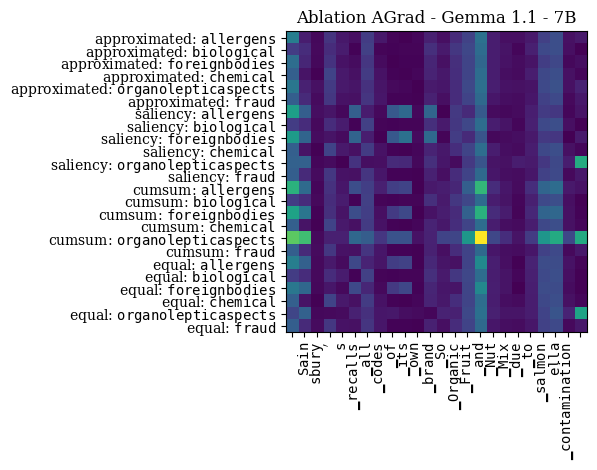

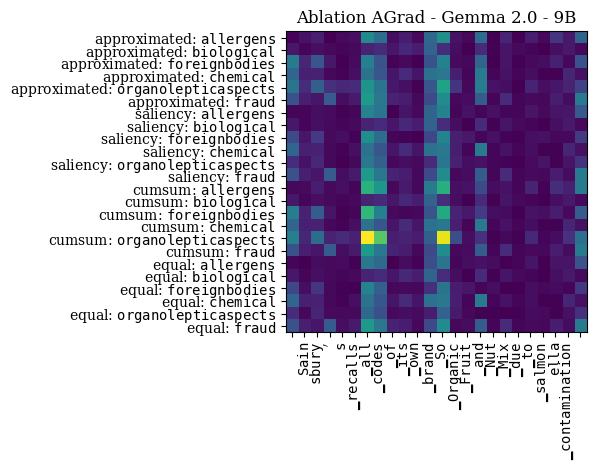

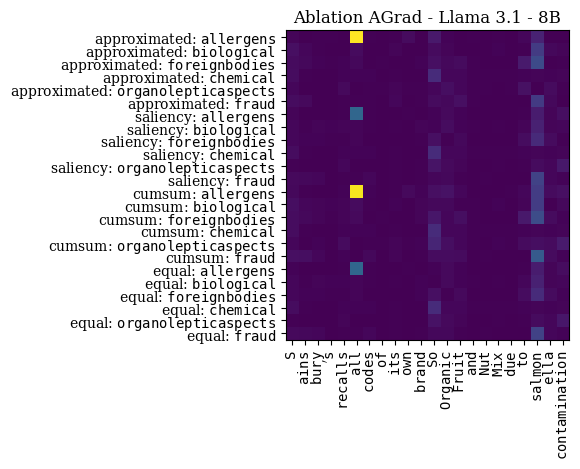

In [19]:
importance_agrad_filtered     = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_agrad_filtered_cls = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_agrad_raw          = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_agrad_raw_cls      = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}

for a in AGGREGATIONS:
    for model in RESULTS:
        for r in RESULTS[model]:
            # get sample boundaries:
            x_start = r['sample']['start']
            x_end   = r['sample']['end']
    
            # get importance:
            importance = r[f'AGrad-{a}'][:, :, x_start:x_end].mean(axis=0)
            importance_raw = np.abs(importance)
            importance_filtered = filter_noise(torch.tensor(importance), epsilon=1e-2).abs().numpy()

            # per token in label:
            importance_agrad_raw[a][model].append({
                LABELS[i]: importance_raw[i]
                for i in range(importance_raw.shape[0])
            })

            importance_agrad_filtered[a][model].append({
                LABELS[i]: importance_filtered[i]
                for i in range(importance_filtered.shape[0])
            })
            
            # only predicted class:
            importance_agrad_filtered_cls[a][model].append(importance_agrad_filtered[a][model][-1][r['label']['text']])
            importance_agrad_raw_cls[a][model].append(importance_agrad_raw[a][model][-1][r['label']['text']])


plotter.plot_importance([importance_agrad_raw[a] for a in AGGREGATIONS], [f'{a}: ' for a in AGGREGATIONS], f'Ablation AGrad')
for a in AGGREGATIONS: pearson.add(importance_agrad_raw_cls[a],           f'$\\bf AGrad$\n({a}, raw)')
for a in AGGREGATIONS: pearson.add(importance_agrad_filtered_cls[a],      f'$\\bf AGrad$\n({a}, filtered)')

# GradIn

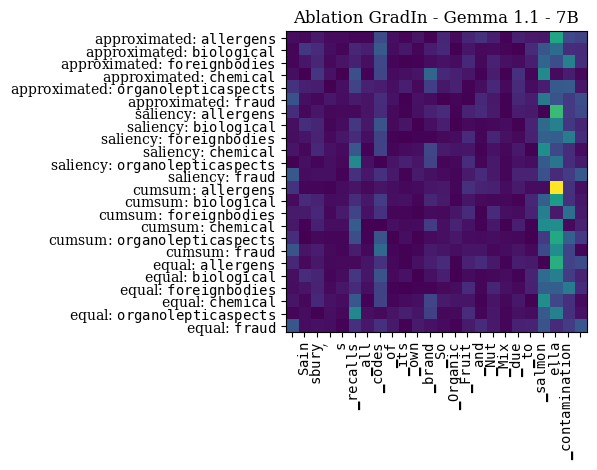

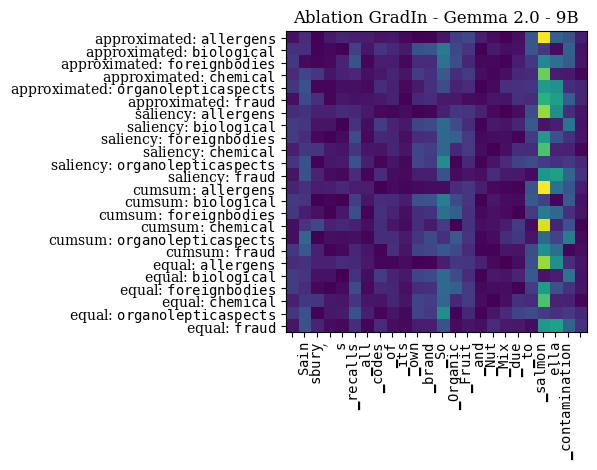

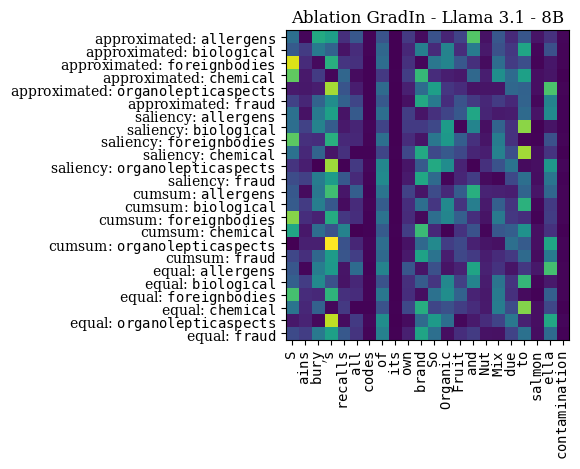

In [20]:
importance_gradin_filtered     = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradin_filtered_cls = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradin_raw          = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradin_raw_cls      = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}

for a in AGGREGATIONS:
    for model in RESULTS:
        for r in RESULTS[model]:
            # get sample boundaries:
            start = r['sample']['start']
            end   = r['sample']['end']
            
            # get importance:
            importance = r[f'GradIn-{a}'][:, start:end]
            importance_raw = np.abs(importance)
            importance_filtered = filter_noise(torch.tensor(importance), epsilon=1e-2).abs().numpy()
            
            # per token in label:
            importance_gradin_raw[a][model].append({
                LABELS[i]: importance_raw[i]
                for i in range(importance_raw.shape[0])
            })

            importance_gradin_filtered[a][model].append({
                LABELS[i]: importance_filtered[i]
                for i in range(importance_filtered.shape[0])
            })
            
            # only predicted class:
            importance_gradin_filtered_cls[a][model].append(importance_gradin_filtered[a][model][-1][r['label']['text']])
            importance_gradin_raw_cls[a][model].append(importance_gradin_raw[a][model][-1][r['label']['text']])

plotter.plot_importance([importance_gradin_filtered[a] for a in AGGREGATIONS], [f'{a}: ' for a in AGGREGATIONS], f'Ablation GradIn')
for a in AGGREGATIONS: pearson.add(importance_gradin_raw_cls[a],           f'$\\bf GradIn$\n({a}, raw)')
for a in AGGREGATIONS: pearson.add(importance_gradin_filtered_cls[a],      f'$\\bf GradIn$\n({a}, filtered)')

# GradH

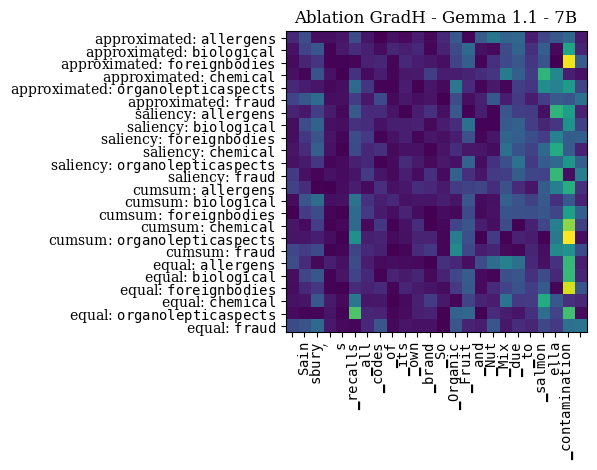

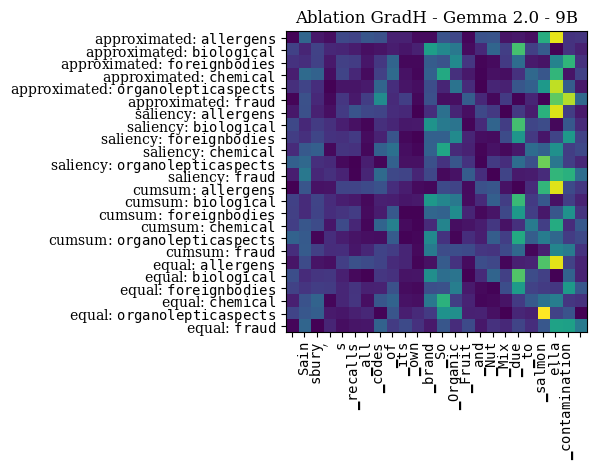

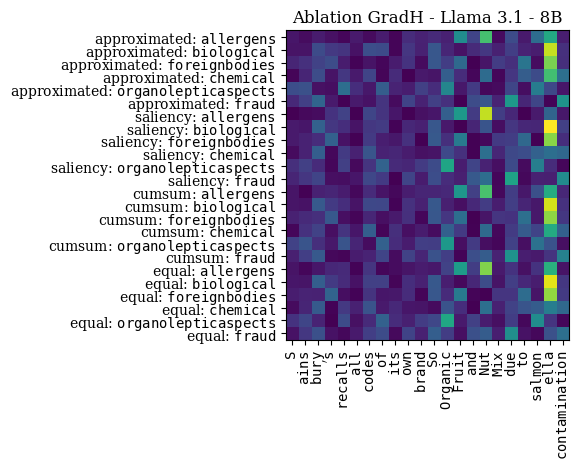

In [21]:
importance_gradh_filtered     = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradh_filtered_cls = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradh_raw          = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}
importance_gradh_raw_cls      = {a: {model:[] for model in RESULTS} for a in AGGREGATIONS}

for a in AGGREGATIONS:
    for model in RESULTS:
        for r in RESULTS[model]:
            # get sample boundaries:
            start = r['sample']['start']
            end   = r['sample']['end']
            
            # get importance:
            importance = r[f'GradH-{a}'][:, start:end]
            importance_raw = np.abs(importance)
            importance_filtered = filter_noise(torch.tensor(importance), epsilon=1e-2).abs().numpy()

            # per token in label:
            importance_gradh_raw[a][model].append({
                LABELS[i]: importance_raw[i]
                for i in range(importance_raw.shape[0])
            })

            importance_gradh_filtered[a][model].append({
                LABELS[i]: importance_filtered[i]
                for i in range(importance_filtered.shape[0])
            })
            
            # only predicted class:
            importance_gradh_filtered_cls[a][model].append(importance_gradh_filtered[a][model][-1][r['label']['text']])
            importance_gradh_raw_cls[a][model].append(importance_gradh_raw[a][model][-1][r['label']['text']])


plotter.plot_importance([importance_gradh_filtered[a] for a in AGGREGATIONS], [f'{a}: ' for a in AGGREGATIONS], f'Ablation GradH')
for a in AGGREGATIONS: pearson.add(importance_gradh_raw_cls[a],           f'$\\bf GradH$\n({a}, raw)')
for a in AGGREGATIONS: pearson.add(importance_gradh_filtered_cls[a],      f'$\\bf GradH$\n({a}, filtered)')

# Shap:

In [22]:
importance_shap_raw_cls = {model:[] for model in RESULTS}
importance_shap_raw =     {model:[] for model in RESULTS}


for model in RESULTS:
    for r in RESULTS[model]:
        if not 'Shap' in r: continue

        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['Shap'][:, start:end])

        # per token in label:
        importance_shap_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only predicted class:
        importance_shap_raw_cls[model].append(importance_shap_raw[model][-1][r['label']['text']])


pearson.add(importance_shap_raw_cls, '$\\bf Shap$\n(precise, cls)')
plotter.plot_importance([importance_shap_raw], ['precise: '], f'Ablation Shap')

IndexError: list index out of range

In [ ]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}

s, l = [], []
for m in METHODS:
    for a in AGGREGATIONS:
        s.extend([eval(f'importance_{m.lower()}_raw_cls')[a], eval(f'importance_{m.lower()}_filtered_cls')[a]])
        l.extend([f'{m} ($\\bf {a}$, $\\bf cls$)', f'{m} ($\\bf {a}$, $\\bf filtered$)'])

plotter.plot_importance(s, l,  f'Ablation Saliency')

# Correlations:

In [ ]:
pearson.matrixplot(title='Pearson Matrix - Ablations', dir=PLOTS_DIR)